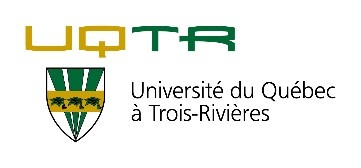

# Deepfake Video Detection through Optical Flow based CNN
### Lahcene Zinnour                                                  
#### UQTR 2020 PIF6014




# 1- Proposed architecture

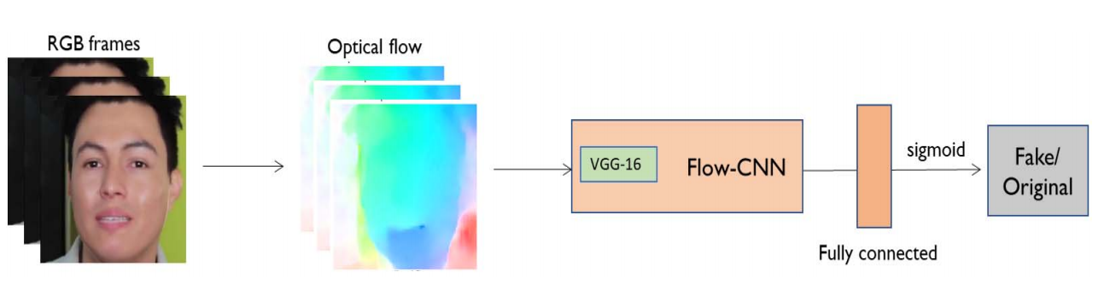

# 2- Data preprocessing

## Video 2 images 

### Original

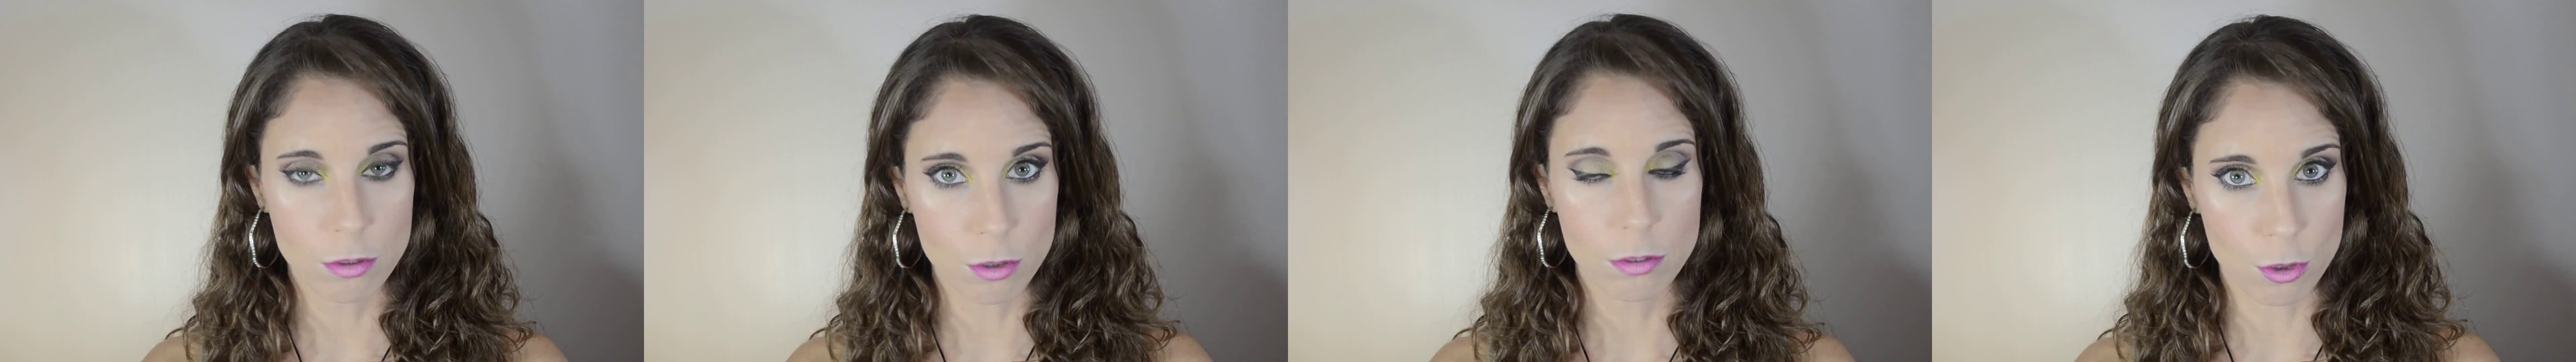

### Fake Face2Face

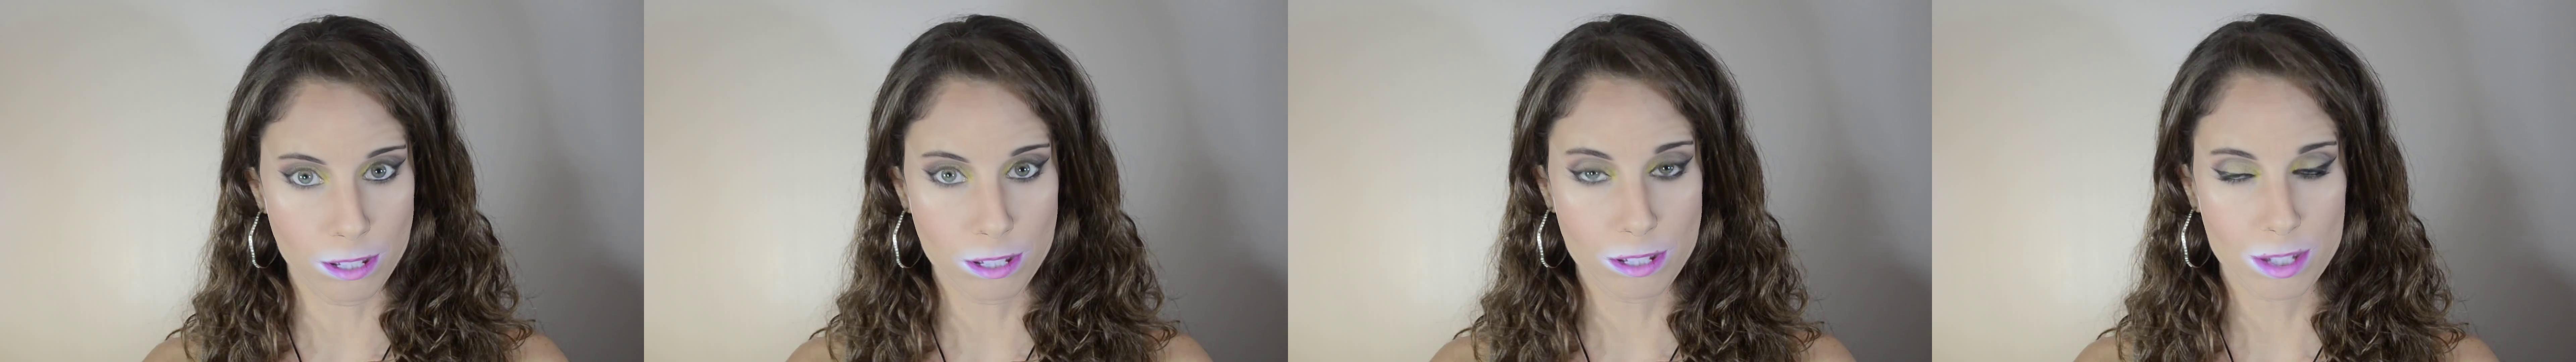

## Face detection

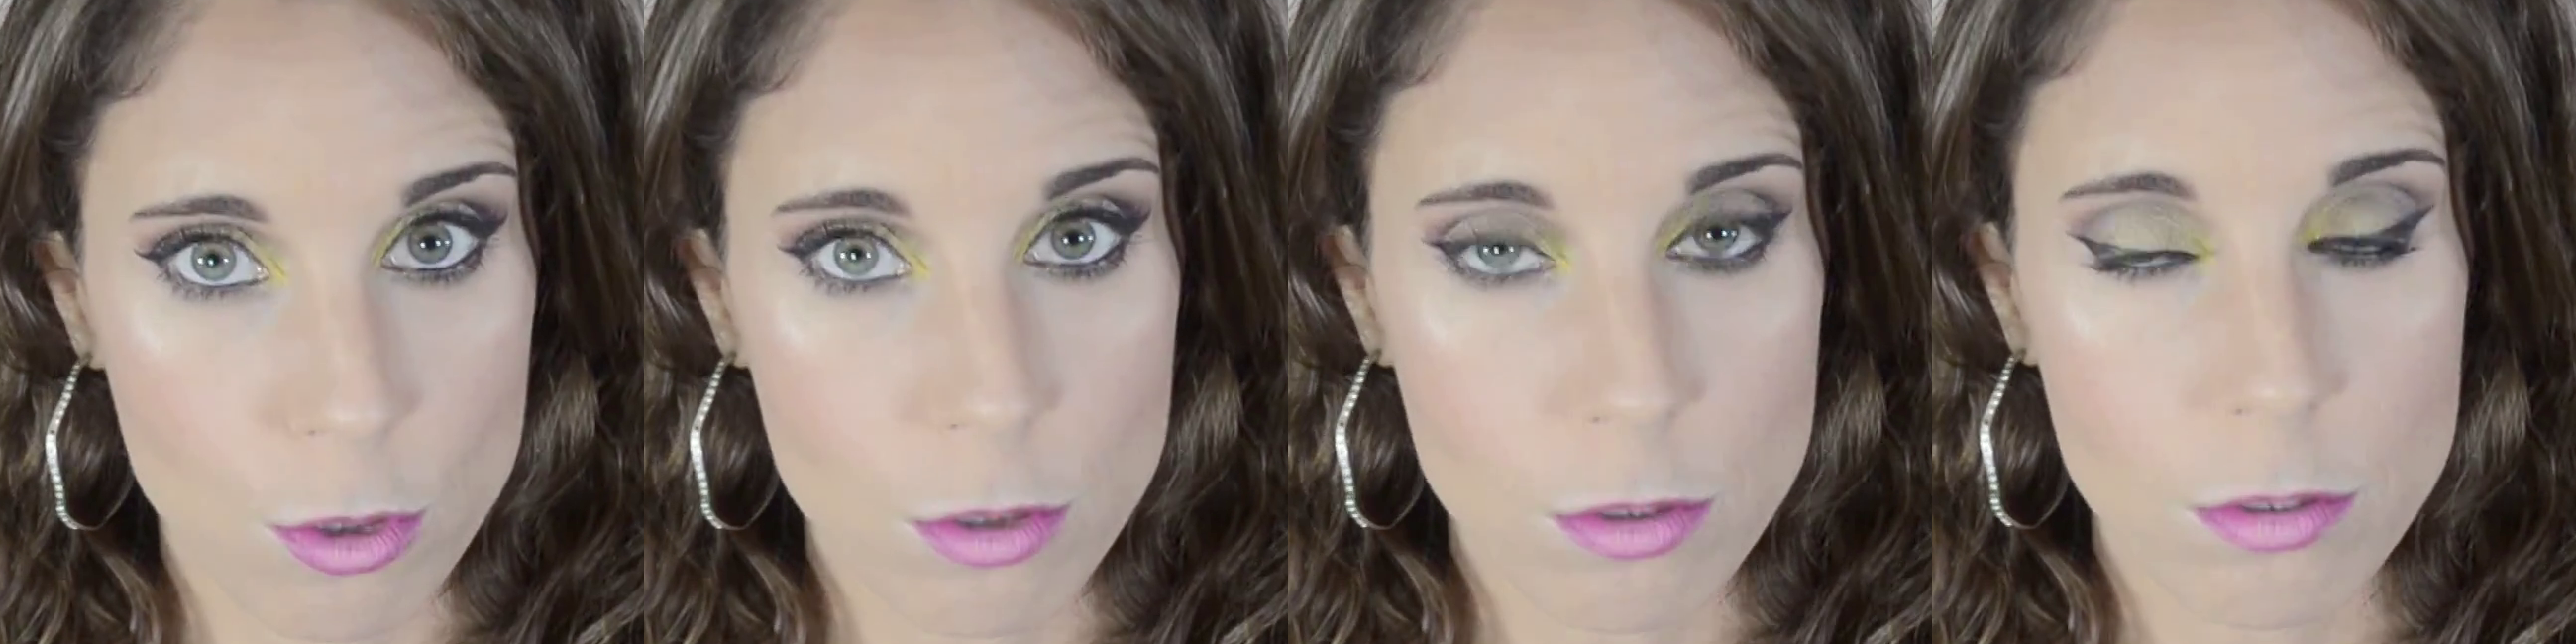

## Optical flow

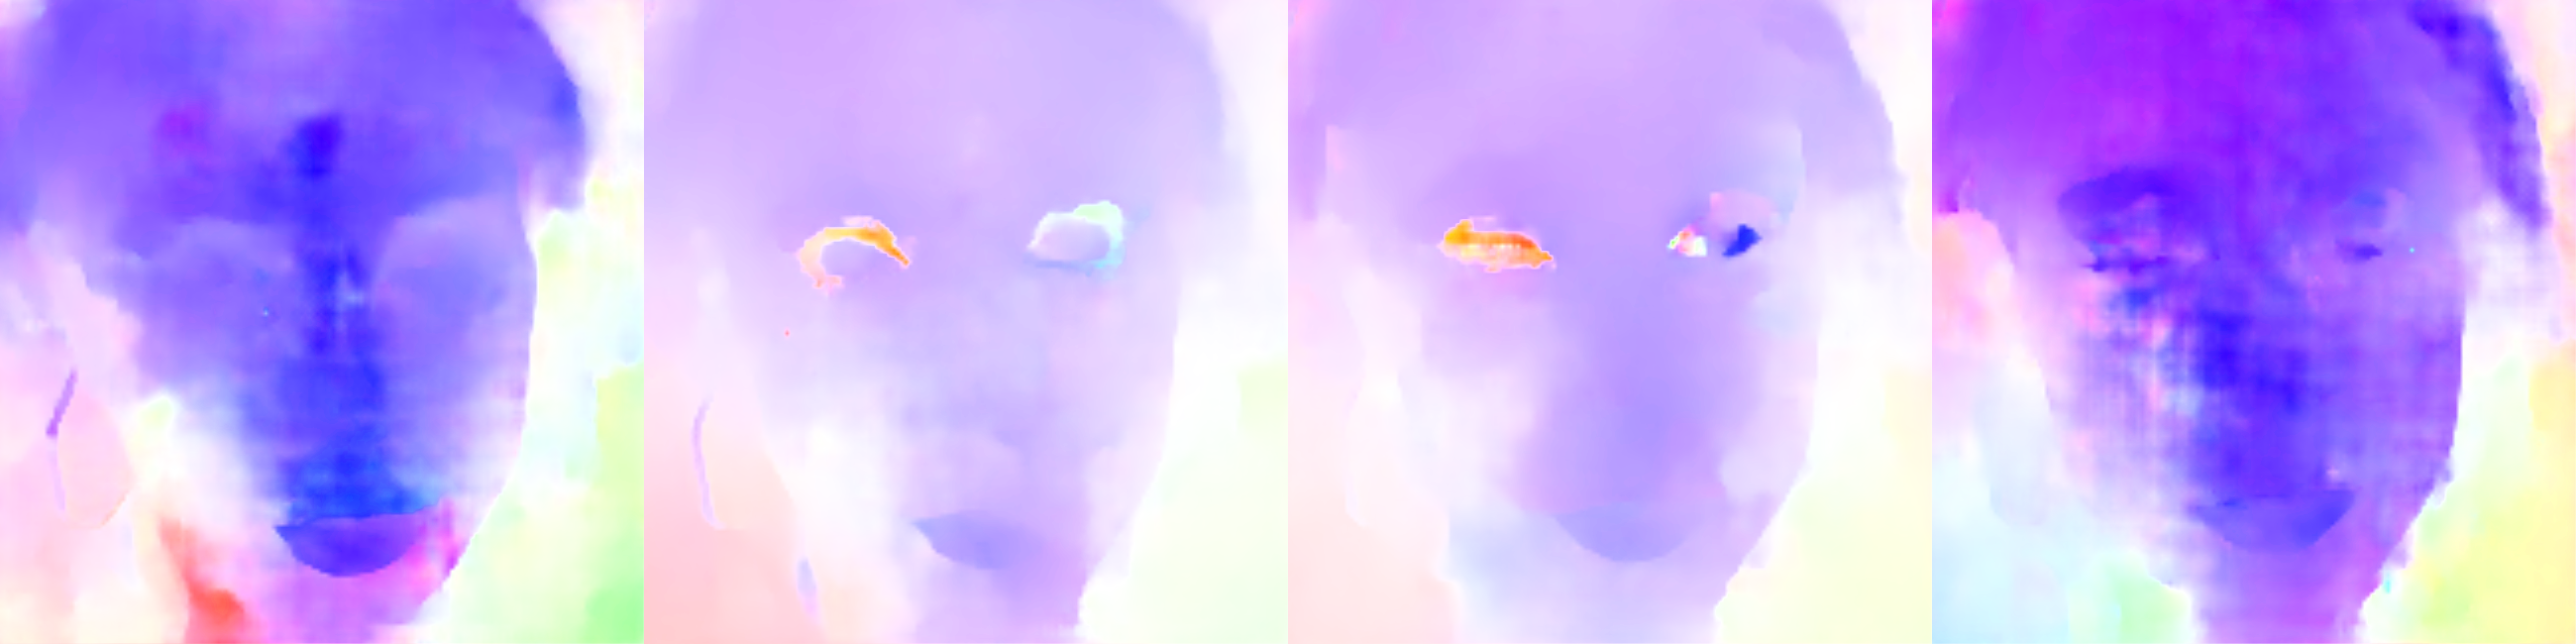




## Tfrecords

### Create


In [ ]:
from __future__ import absolute_import, division, print_function
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from copy import deepcopy
from skimage.io import imread, imsave
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf
from os.path import join

class GenerateTFRecord:
    
        
    def _int64_feature(self, value):
        return tf.train.Feature(
                int64_list=tf.train.Int64List(value=[value])
             )
    def _floats_feature(self, value):
        return tf.train.Feature(
                   float_list=tf.train.FloatList(value=value)
               )
    def _bytes_feature(self, value):
        return tf.train.Feature(
                  bytes_list=tf.train.BytesList(value=[value])
             )
      
      
    def load_image(self, path):
        img = cv2.imread(path)
        # cv2 load images as BGR, convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        return img
    
    def get_feature(self, image, label, height, width):
        return {
                'image': self._bytes_feature(tf.compat.as_bytes(image.tostring())),
                'label': self._int64_feature(label),
                'height': self._int64_feature(height),
                'width': self._int64_feature(width)
                }
    
    def createTfRecord(self, images_path, label, height, width, output_file_path):
        with tf.io.TFRecordWriter(output_file_path) as writer:
            for index in range(len(images_path)):
                img = self.load_image(images_path[index])
                example = tf.train.Example(
                  features=tf.train.Features(
                      feature = self.get_feature(img, label, height, width)
                ))
                writer.write(example.SerializeToString())
                print('\r{:.1%}'.format((index+1)/len(images_path)), end='')
                
                
    def run(self, input_path, output_path):
        output_path = join(output_path, "tfrecords")
        os.makedirs(output_path)
        imgs_path = []
        
        #To extract height and width
        path, dirs2, files = next(os.walk(input_path))
        image_path = input_path+"/"+files[0]
        image = imread(image_path)
        h, w, c = image.shape
        
        for images in os.listdir(input_path):
            img_path = join(input_path +'/'+ images)
            imgs_path.append(img_path)
        tf = join(output_path, "tf.tfrecords")
        self.createTfRecord(imgs_path, 1, h, w, tf)
        
        return tf

### Load

In [ ]:
class ReadTFRecord:
    
    
    def get_tfrecords_features(self):
        print("get_tfrecords_features")
        return {
        'image': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([], tf.int64),
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64)
        }
    
    def load_tfrecords(self, tfrecords_filepath):
        items = []
        labels = []
        print("Loading %s" % tfrecords_filepath)
        with tf.Session() as sess:
            for serialized_example in tf.python_io.tf_record_iterator(tfrecords_filepath):
                data, label = self.feature_retrieval(serialized_example)
                items.append(data)
                labels.append(label)
        print("Finished Loading %s" % tfrecords_filepath)
        return (tf.stack(items), tf.stack(labels))
    
    def feature_retrieval(self, serialized_example):
        print("feature_retrieval")
        
        example  = tf.parse_single_example(serialized_example, features=self.get_tfrecords_features())
        
        
        image = tf.cast(example ['image'], tf.string)
        height = tf.cast(example ['height'], tf.int64)
        width = tf.cast(example ['width'], tf.int64)
        label = tf.cast(example ['label'], tf.int64)
        
        image_shape = tf.stack([height, width, 3])
        image_raw = tf.decode_raw(image, tf.float32)
        image = tf.reshape(image_raw, image_shape)

        image = tf.image.resize_images(image, [120, 120])
        label = tf.one_hot(label, 1)
        #label.set_shape([None,1])
        
        return image, label
    
    
        
    def prepare_data(self, filename_queue):
        print("prepare_data")
        
        # This works with arrays as well, num_parallel_reads = 8
        #dataset = tf.data.TFRecordDataset(filenames = filename_queue, num_parallel_reads = 6)
        files = tf.data.Dataset.list_files(filename_queue)
        dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x).prefetch(100), cycle_length=2, block_length=128)


        # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
        dataset = dataset.map(self.feature_retrieval, num_parallel_calls = 2)

        # Set the batchsize, drop_remainder=True
        batch_size = 256
        dataset = dataset.shuffle(1000 + 3 * batch_size )
        dataset = dataset.repeat(100)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(1) 
       
        return dataset

# 3- Training

## Data preparation (training, validation, test)


In [ ]:
def prepare_training_data(self, opticalFlowOriginalPath, opticalFlowFakePath):
        original = tf.gfile.Glob(opticalFlowOriginalPath)
        fake = tf.gfile.Glob(opticalFlowFakePath)
        
        original_size = len(original)
        original_train = original[0 : int(0.8*original_size)]
        original_val = original[int(0.8*original_size) : int(0.9*original_size)]
        original_test = original[int(0.9*original_size) : -1]
        
        
        fake_size = len(fake)
        fake_train = fake[0 : int(0.8*fake_size)]
        fake_val = fake[int(0.8*fake_size) : int(0.9*fake_size)]
        fake_test = fake[int(0.9*fake_size) : -1]
        
        
        min_train = min(len(original_train), len(fake_train))
        data_train = [None]*(min_train*2)
        data_train[::2] = original_train[:min_train]
        data_train[1::2] = fake_train[:min_train]
        data_train.extend(original_train[min_train:])
        data_train.extend(fake_train[min_train:])
        
        min_val = min(len(original_val), len(fake_val))
        data_val = [None]*(min_val*2)
        data_val[::2] = original_val[:min_val]
        data_val[1::2] = fake_val[:min_val]
        data_val.extend(original_val[min_val:])
        data_val.extend(fake_val[min_val:])
        
        min_test = min(len(original_test), len(fake_test))
        data_test = [None]*(min_test*2)
        data_test[::2] = original_test[:min_test]
        data_test[1::2] = fake_test[:min_test]
        data_test.extend(original_test[min_test:])
        data_test.extend(fake_test[min_test:])
        
        return data_train, data_val, data_test  

## Model (VGG16)

In [2]:
from tensorflow.keras import applications
m = applications.VGG16(weights='imagenet')
m.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Transfer Learning — Pre-trained CNN (VGG16) with Fine-tuning 

In [ ]:

class vgg16:
    
    def model(self, training_dataset, validation_dataset, test_dataset):
        input_tensor = Input(shape=(120, 120, 3))
        vgg_model = applications.VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
    
        # Freeze the layers except the last 4 layers
        for layer in vgg_model.layers[:-4]:
            layer.trainable = False
    
        # Check the trainable status of the individual layers
        for layer in vgg_model.layers:
            print(layer, layer.trainable)
        
        # Create the model
        model = models.Sequential()
    
        # Add the vgg convolutional base model
        model.add(vgg_model)
        
        # Classification block
        model.add(Flatten(name='flatten'))
        model.add(Dense(4096, activation='relu', name='fc1'))
        model.add(Dense(4096, activation='relu', name='fc2'))
        model.add(Dense(1, activation='sigmoid', name='predictions'))
        
        #lr_sched = r.step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=976)
        
        adam = optimizers.Adam(lr=0.0001)
        model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        
    
        # Show a summary of the model. Check the number of trainable parameters
        model.summary()
        model_name = "deepfake_model-{}".format(int(time.time()))
        checkpoint = ModelCheckpoint("best_deepfake_model.h5", monitor='loss', verbose=1, save_best_only=True, mode='auto', period=1)
        
        history = model.fit(training_dataset, validation_data=validation_dataset,validation_steps=140,
                            epochs=3,
                            steps_per_epoch=960,
                            callbacks=[checkpoint])
        
        # Save the model
        model.save(model_name)
        

In [3]:
from __future__ import absolute_import, division, print_function
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys

import tensorflow as tf
import glob, os
from tensorflow.python.lib.io import file_io
from tensorflow.keras import applications
from tensorflow.keras import models, datasets
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Reshape, Input, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from keras.callbacks import Callback
import numpy as np
import time
from random import shuffle
np.set_printoptions(threshold=sys.maxsize)
import keras.backend as K
from keras.callbacks import LearningRateScheduler



input_tensor = Input(shape=(120, 120, 3))
vgg_model = applications.VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze the layers except the last 4 layers
for layer in vgg_model.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_model.layers:
    print(layer, layer.trainable)

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_model)

# Classification block
model.add(Flatten(name='flatten'))
model.add(Dense(4096, activation='relu', name='fc1'))
model.add(Dense(4096, activation='relu', name='fc2'))
model.add(Dense(1, activation='sigmoid', name='predictions'))

model.summary()

Using TensorFlow backend.


<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000189AC821B88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000018912235148> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000189AC9CC648> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000189AC9E4B08> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000189AC9F5E88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000189AC9EE6C8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000189ACA0BC88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000189ACA19608> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000189ACA22388> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000189ACA22308> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000189ACA47DC8> False
<tensorflow.python.

# 4- Demo

In [1]:

class deepfake_console:
    
    
    def get_tfrecords_features(self):
        print("get_tfrecords_features")
        return {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64)
        }
    
    def feature_retrieval(self, serialized_example):
        print("feature_retrieval")
        
        example  = tf.io.parse_single_example(serialized_example, features=self.get_tfrecords_features())
        
        
        image = tf.cast(example ['image'], tf.string)
        height = tf.cast(example ['height'], tf.int64)
        width = tf.cast(example ['width'], tf.int64)
        label = tf.cast(example ['label'], tf.int64)
        
        image_shape = tf.stack([height, width, 3])
        image_raw = tf.io.decode_raw(image, tf.float32)
        image = tf.reshape(image_raw, image_shape)

        image = tf.image.resize(image, [120, 120])
        label = tf.one_hot(label, 1)
        #label.set_shape([None,1])
        
        return image, label
    
    
        
    def prepare_data(self, filename_queue, nb_images):
        
        # This works with arrays as well, num_parallel_reads = 8
        #dataset = tf.data.TFRecordDataset(filenames = filename_queue, num_parallel_reads = 6)
        files = tf.data.Dataset.list_files(filename_queue)
        dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x).prefetch(tf.data.experimental.AUTOTUNE))


        # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
        dataset = dataset.map(self.feature_retrieval, num_parallel_calls = tf.data.experimental.AUTOTUNE)

        # This dataset will go on forever

        # Set the number of datapoints you want to load and shuffle 
        dataset = dataset.shuffle(200)

        # Set the batchsize, drop_remainder=True
        batch_size = nb_images
        dataset = dataset.repeat(tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.prefetch(1) 
        
        return dataset
    
    
    def vgg16(self, dataset):
        
        input_tensor = Input(shape=(120, 120, 3))
        vgg_model = applications.VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
    
        # Freeze the layers except the last 4 layers
        for layer in vgg_model.layers[:-4]:
            layer.trainable = False
        
        # Create the model
        model = models.Sequential()
    
         # Add the vgg convolutional base model
        model.add(vgg_model)
        # Classification block
        model.add(Flatten(name='flatten'))
        model.add(Dense(4096, activation='relu', name='fc1'))
        model.add(Dense(4096, activation='relu', name='fc2'))
        model.add(Dense(1, activation='sigmoid', name='predictions'))
        adam = optimizers.Adam(lr=0.0001)
        model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        # Loads the weights
        model.load_weights("cnn1.h5")
        
        # evaluate the model
        acc = model.predict(dataset, steps=1)
        print("++++++++++++++++++++++++++++++++++++++++")
        print(statistics.mean(acc.ravel()))
        if statistics.mean(acc.ravel()) <= 0.5:
            print("Original")
        else:
            print("Fake")
        
        
        
    
    
if __name__ == '__main__':
    
    print("Processing images in folder:", input)
    
    p = argparse.ArgumentParser()
    p.add_argument('--video_path', '-i',
                   default=None)
    
    args = p.parse_args()
    vargs = vars(args)
    
    if args.video_path == None:
        print('Need a video')
        sys.exit()
    
    video_path = args.video_path
    
    """path, dirs, files = next(os.walk(os.path.dirname("C:/Users/deepfake/Desktop/fake videos/")))
    for pair in range(0, len(files)):
        tf_path = path+"/"+files[pair]"""
    
    images_dir, nb_images = extract_sequences(video_path)
    
    video_dir = autocrop_faces(images_dir)
    optical_flow = pwcnet(video_dir)
    
    tfrecords_path = GenerateTFRecord().run(optical_flow, video_dir)
    tfrecords_path = tf.io.gfile.glob(tfrecords_path)
    
    df = deepfake_console()
    dataset = df.prepare_data(tfrecords_path, nb_images)
    df.vgg16(dataset)
        
        

D:/Deepfake/Data preprocessing/autocrop\haarcascade_frontalface_default.xml


Using TensorFlow backend.


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Processing images in folder: <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x000001CC2E418708>>
prepare_data
feature_retrieval
get_tfrecords_features
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001CC3BA3ED48> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001CC3B9695C8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001CC3BAB3E88> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001CC3BA5A288> False
<tensorflow.pyt

# 6- CNN-LSTM?

## Spatial features (CNN) + Temporal features (RNN)

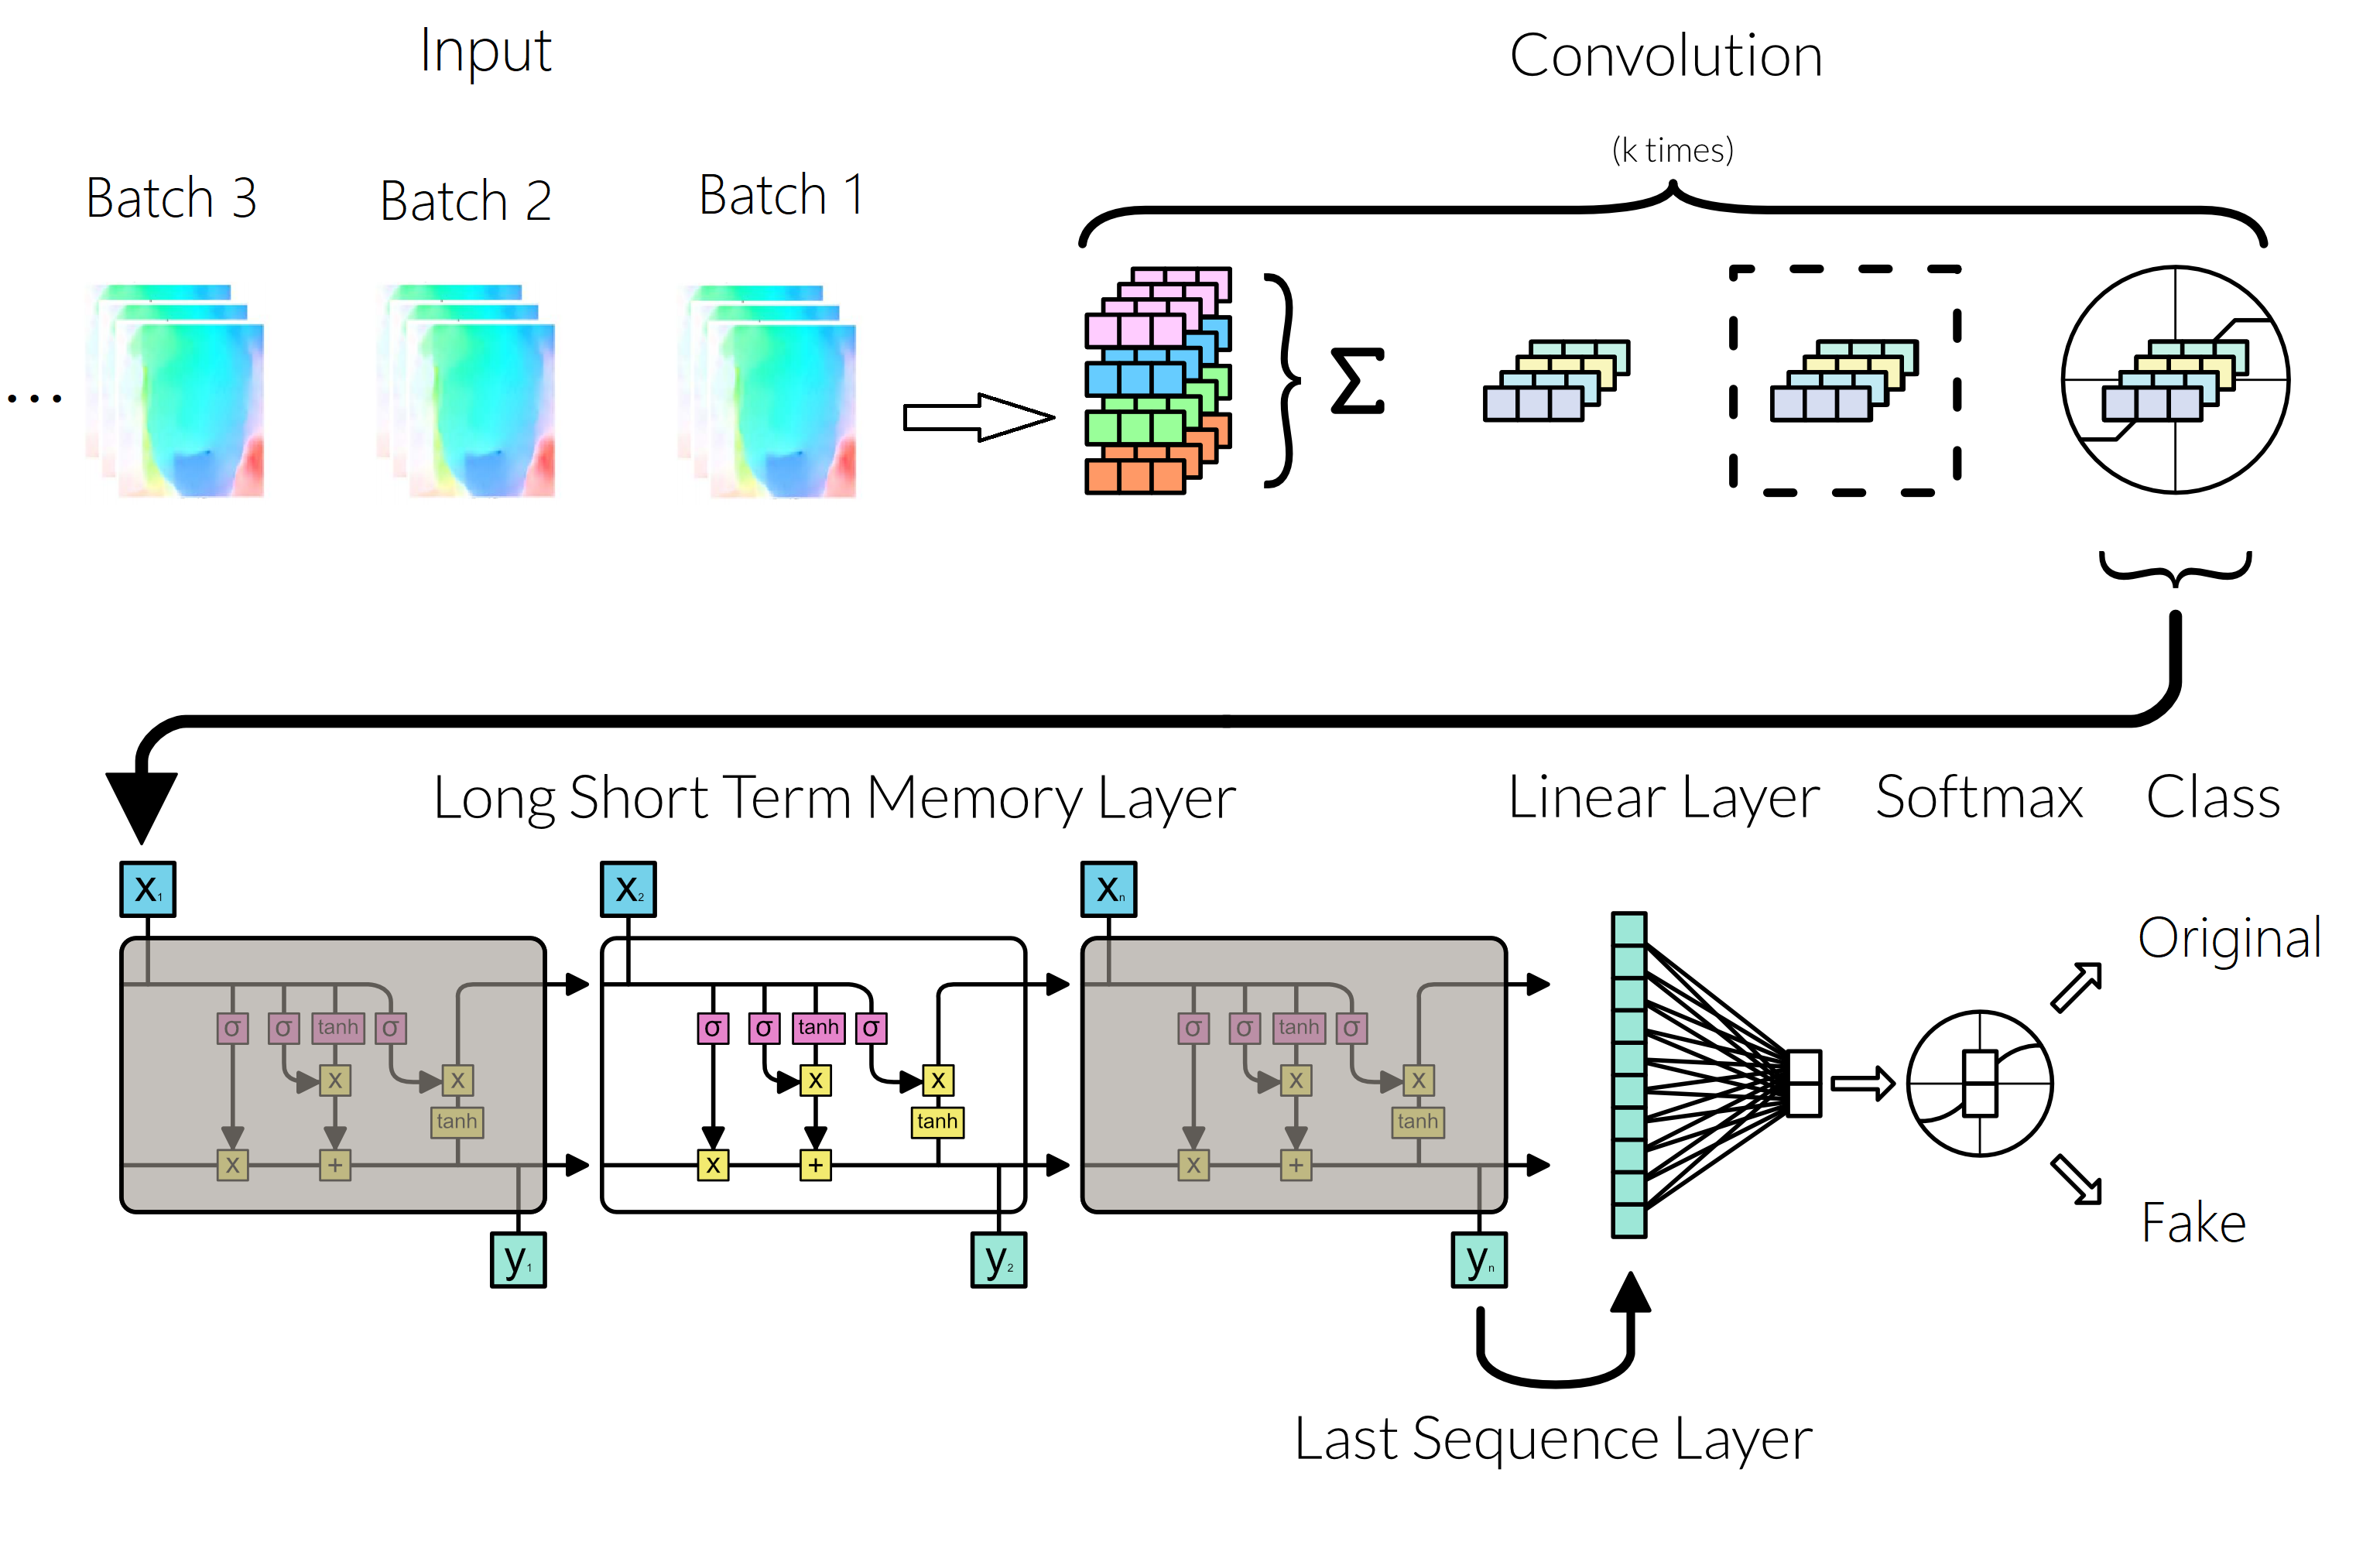